Формирование разметки и анализ баланса классов

# Загрузка библиотек

In [47]:
import os
import ast
import json 
import hashlib
import imagehash
import pandas as pd
from PIL import Image, ImageOps, ImageFile
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from random import sample
import matplotlib.patches as patches

In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Формирование файла с разметкой

In [3]:
path_data = Path('../data/terminal_object_detection_data/')
path_photos = path_data / 'photos'
path_via_annots = path_data / 'via_annot'
path_yolo_annots = path_data / 'yolo_annot'

In [4]:
dict_markup = {}
for root, dirs, files in os.walk(path_photos):
    if len(files)!=0 and len(dirs)==0:
        dict_markup[root.split('\\')[-1]] = files

In [5]:
dict_markup = {}
for folder in os.listdir(path_photos):
    curr_folder = path_photos / folder
    dict_markup[folder] = [(curr_folder / filename).__str__() for filename in os.listdir(curr_folder)]

In [6]:
keys, vals = [], []
for key, values in dict_markup.items():
    vals.extend(values)
    keys.extend([key for _ in values])

In [7]:
df_markup = pd.DataFrame({
    'filename': vals,
    'flags': keys
})

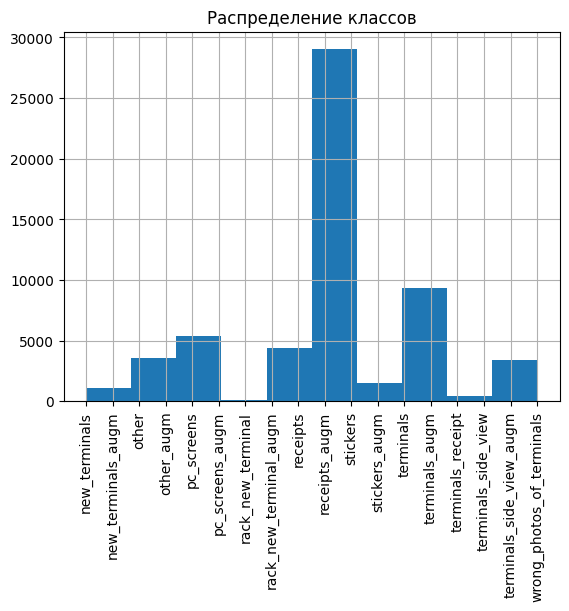

In [8]:
df_markup['flags'].hist()
plt.title('Распределение классов')
plt.xticks(rotation=90)
plt.show()

In [9]:
df_markup.head()

,filename,flags
0,..\data\terminal_object_detection_data\photos\...,new_terminals
1,..\data\terminal_object_detection_data\photos\...,new_terminals
2,..\data\terminal_object_detection_data\photos\...,new_terminals
3,..\data\terminal_object_detection_data\photos\...,new_terminals
4,..\data\terminal_object_detection_data\photos\...,new_terminals


In [10]:
df_markup.to_pickle('markup.pkl')

# Поворот картинок в соответствии с метаданными

In [11]:
for filename in tqdm(df_markup['filename']):
    image = Image.open(filename)
    image = ImageOps.exif_transpose(image)
    image.save(filename) 
    image.close()

  0%|          | 0/58274 [00:00<?, ?it/s]

 24%|██▍       | 14105/58274 [17:41<55:22, 13.29it/s]   


KeyboardInterrupt: 

# Формирование разметки в формате YOLO

## "Старые" терминалы

In [12]:
df_terminals = df_markup.loc[
    df_markup['flags']=='terminals'
]
df_markup_terminals = pd.read_csv(path_via_annots / 'terminals/terminal_object_detection_terminal.csv')
df_terminals.loc[:, 'short_filename'] = df_terminals.loc[:, 'filename'].apply(lambda x: x.split('\\')[-1])
df_merged_old = df_terminals.merge(
    df_markup_terminals, left_on='short_filename',
    right_on='filename', how='left'
)

C:\Users\dimaz\AppData\Local\Temp\ipykernel_17912\4188388250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_terminals.loc[:, 'short_filename'] = df_terminals.loc[:, 'filename'].apply(lambda x: x.split('\\')[-1])


In [14]:
df_merged_old.head()

,filename_x,flags,short_filename,filename_y,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,..\data\terminal_object_detection_data\photos\...,terminals,IM0204623687_20941974_10046734.jpg,IM0204623687_20941974_10046734.jpg,302998,{},1,0,"{""name"":""rect"",""x"":4,""y"":372,""width"":974,""heig...","{""terminal"":""terminal""}"
1,..\data\terminal_object_detection_data\photos\...,terminals,IM0204723209_20977550_23444131.jpg,IM0204723209_20977550_23444131.jpg,111710,{},1,0,"{""name"":""rect"",""x"":279,""y"":294,""width"":646,""he...","{""terminal"":""terminal""}"
2,..\data\terminal_object_detection_data\photos\...,terminals,IM0204749869_20993690_25001898_1_.jpeg,IM0204749869_20993690_25001898_1_.jpeg,371758,{},2,0,"{""name"":""rect"",""x"":611,""y"":558,""width"":531,""he...","{""terminal"":""terminal""}"
3,..\data\terminal_object_detection_data\photos\...,terminals,IM0204749869_20993690_25001898_1_.jpeg,IM0204749869_20993690_25001898_1_.jpeg,371758,{},2,1,"{""name"":""rect"",""x"":0,""y"":359,""width"":297,""heig...","{""terminal"":""terminal""}"
4,..\data\terminal_object_detection_data\photos\...,terminals,IM0204770769_21004848_25930553_1_.jpg,IM0204770769_21004848_25930553_1_.jpg,302032,{},1,0,"{""name"":""rect"",""x"":124,""y"":554,""width"":1147,""h...","{""terminal"":""terminal""}"


In [15]:
df_merged_old.columns

Index(['filename_x', 'flags', 'short_filename', 'filename_y', 'file_size',
       'file_attributes', 'region_count', 'region_id',
       'region_shape_attributes', 'region_attributes'],
      dtype='object')

In [16]:
df_merged_old = df_merged_old[['filename_x', 'short_filename', 'region_shape_attributes', 'region_attributes']].rename(
    columns={'filename_x': 'filename'}
)

In [19]:
df_merged_old.drop_duplicates(subset=['filename'], inplace=True)

In [22]:
dict_terminal_match = {
    'terminal': 0,
    'pax_im20': 1,
    'white_terminal': 2
}

In [23]:
df_merged_old['terminal_type'] = df_merged_old['region_attributes'].apply(
    lambda x: dict_terminal_match[ast.literal_eval(x)['terminal']]
)

In [18]:
for filename in tqdm(df_merged_old['filename'].unique()):
    df_image = df_merged_old.loc[
        df_merged_old['filename']==filename
    ].copy()
    df_image['region_shape_attributes'] = df_image['region_shape_attributes'].apply(
        lambda x: ast.literal_eval(x)
    )
    end = filename.split('.')[-1]
    filename_label = path_yolo_annots / 'terminals' / filename.split('\\')[-1].replace(end, 'txt')
    im_width, im_height = Image.open(filename).size
    with open(filename_label, 'w') as file:
        for i, row in enumerate(df_image.iterrows()):
            row = row[1]
            terminal_type = row['terminal_type']
            region = row['region_shape_attributes']
            x, y, width, height = region['x'], region['y'], region['width'], region['height']
            if y<0:
                height += y
                y = 0
            x_c, y_c = region['x'] + (width / 2), region['y'] + (height / 2)
            x_c_yolo, y_c_yolo, width_yolo, height_yolo = (
                x_c / im_width, y_c / im_height, 
                width / im_width, height / im_height
            )
            str_ = f'{terminal_type} {x_c_yolo} {y_c_yolo} {width_yolo} {height_yolo}'
            if i!=df_image.shape[0]: str_ += '\n'
            file.write(str_)

100%|██████████| 2390/2390 [00:23<00:00, 102.87it/s]


### Проверка

In [24]:
def read_yolo_markup(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    markup = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        markup.append((class_id, x_center, y_center, width, height))
    return markup

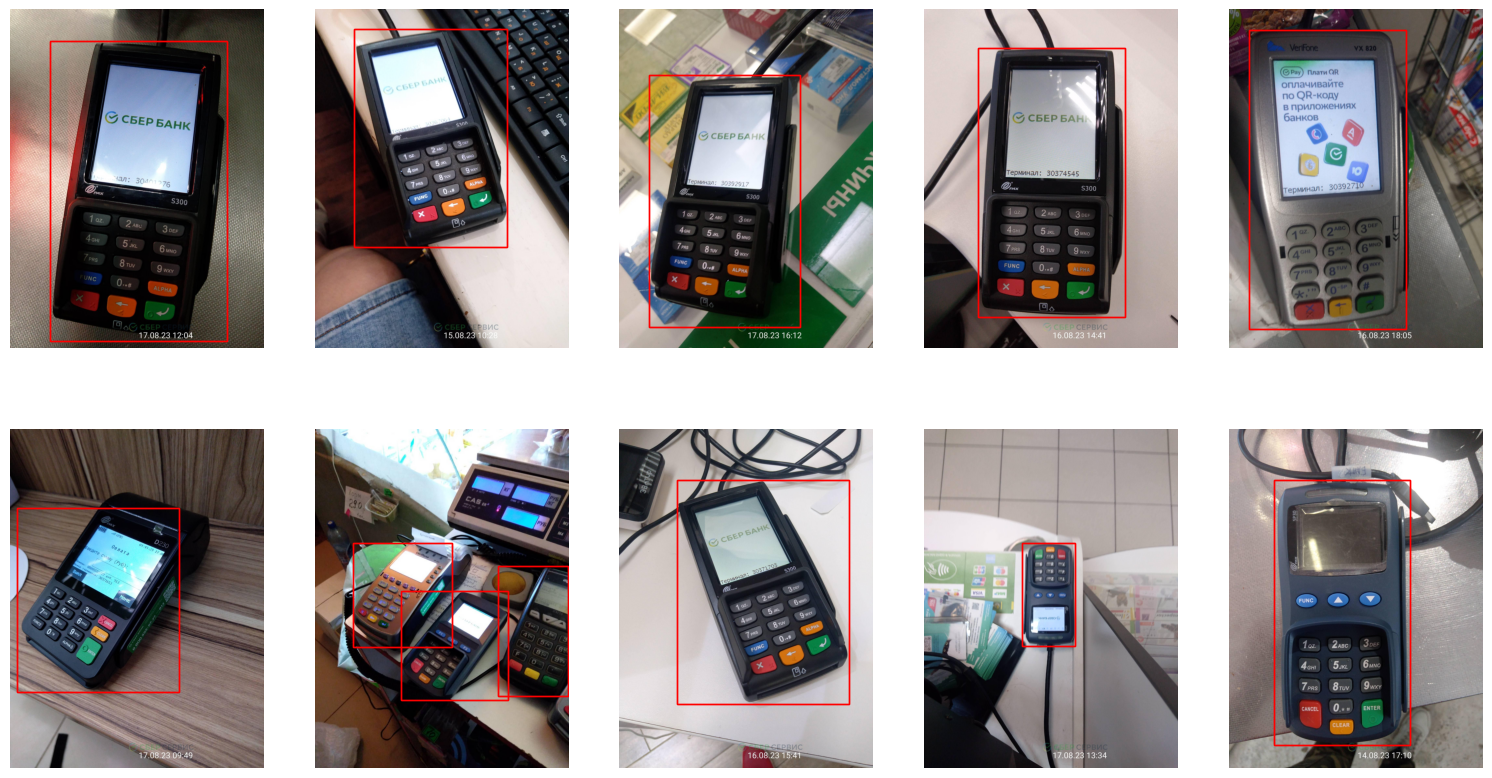

In [25]:
random_images = sample(sorted(df_merged_old['filename'].unique()), 10)
fig, axs = plt.subplots(2, 5, figsize=(19, 10))
for i, ax in enumerate(axs.ravel()):
    random_image = random_images[i]
    image = Image.open(random_image)
    ax.imshow(image)
    ax.axis('off')
    end = random_image.split('.')[-1]
    file_label = random_image.replace('photos', 'yolo_annot').replace(end, 'txt')
    markup = read_yolo_markup(file_label)
    for class_id, x_center, y_center, width, height in markup:
        x_c, y_c, w, h = (
            x_center * image.size[0], y_center * image.size[1], 
            width * image.size[0], height  * image.size[1]
        )
        x_min = (x_c - (w//2))
        y_min = (y_c - (h//2))
        rect = patches.Rectangle((x_min, y_min), w, h, linewidth=1,
                                    edgecolor='r', facecolor='none')
        ax.add_patch(rect)
plt.show()

## Новые терминалы

In [26]:
df_markup['flags'].unique()

array(['new_terminals', 'new_terminals_augm', 'other', 'other_augm',
       'pc_screens', 'pc_screens_augm', 'rack_new_terminal',
       'rack_new_terminal_augm', 'receipts', 'receipts_augm', 'stickers',
       'stickers_augm', 'terminals', 'terminals_augm',
       'terminals_receipt', 'terminals_side_view',
       'terminals_side_view_augm', 'wrong_photos_of_terminals'],
      dtype=object)

In [27]:
df_terminals = df_markup.loc[
    df_markup['flags']=='new_terminals'
]
df_markup_terminals = pd.read_csv(path_via_annots / 'new_terminals/new_terminals.csv')
df_terminals.loc[:, 'short_filename'] = df_terminals.loc[:, 'filename'].apply(lambda x: x.split('\\')[-1])
df_merged_new = df_terminals.merge(
    df_markup_terminals, left_on='short_filename',
    right_on='filename', how='left'
)

C:\Users\dimaz\AppData\Local\Temp\ipykernel_17912\448948399.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_terminals.loc[:, 'short_filename'] = df_terminals.loc[:, 'filename'].apply(lambda x: x.split('\\')[-1])


In [28]:
df_merged_new.head()

,filename_x,flags,short_filename,filename_y,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,..\data\terminal_object_detection_data\photos\...,new_terminals,IM0204731777_20982914_30247553.jpg,IM0204731777_20982914_30247553.jpg,238192,{},1,0,"{""name"":""rect"",""x"":326,""y"":90,""width"":289,""hei...","{""terminal"":""white_terminal""}"
1,..\data\terminal_object_detection_data\photos\...,new_terminals,IM0204764217_21001792_23935536.jpg,IM0204764217_21001792_23935536.jpg,185808,{},1,0,"{""name"":""rect"",""x"":46,""y"":826,""width"":117,""hei...","{""terminal"":""white_terminal""}"
2,..\data\terminal_object_detection_data\photos\...,new_terminals,IM0204877219_21052712_23261677_2_.jpeg,IM0204877219_21052712_23261677_2_.jpeg,179377,{},1,0,"{""name"":""rect"",""x"":216,""y"":495,""width"":664,""he...","{""terminal"":""white_terminal""}"
3,..\data\terminal_object_detection_data\photos\...,new_terminals,IM0204884147_21055766_22559624_6_.jpeg,IM0204884147_21055766_22559624_6_.jpeg,296264,{},1,0,"{""name"":""rect"",""x"":4,""y"":156,""width"":1272,""hei...","{""terminal"":""white_terminal""}"
4,..\data\terminal_object_detection_data\photos\...,new_terminals,TS904426580-cbd34f09-8b17-42ad-8337-d5992fa8a5...,TS904426580-cbd34f09-8b17-42ad-8337-d5992fa8a5...,144465,{},1,0,"{""name"":""rect"",""x"":52,""y"":351,""width"":1104,""he...","{""terminal"":""white_terminal""}"


In [29]:
df_merged_new.columns

Index(['filename_x', 'flags', 'short_filename', 'filename_y', 'file_size',
       'file_attributes', 'region_count', 'region_id',
       'region_shape_attributes', 'region_attributes'],
      dtype='object')

In [ ]:
df_merged_new = df_merged_new[['filename_x', 'short_filename', 'region_shape_attributes', 'region_attributes']].rename(
    columns={'filename_x': 'filename'}
)


In [36]:
df_merged_new.shape

(292, 5)

In [37]:
df_merged_new.drop_duplicates(subset=['filename'], inplace=True)
df_merged_new.shape

(292, 5)

In [38]:
dict_terminal_match = {
    'terminal': 0,
    'pax_im20': 1,
    'white_terminal': 2
}

In [39]:
df_merged_new['terminal_type'] = df_merged_new['region_attributes'].apply(
    lambda x: dict_terminal_match[ast.literal_eval(x)['terminal']]
)

In [42]:
for filename in tqdm(df_merged_new['filename'].unique()):
    df_image = df_merged_new.loc[
        df_merged_new['filename']==filename
    ].copy()
    df_image['region_shape_attributes'] = df_image['region_shape_attributes'].apply(
        lambda x: ast.literal_eval(x)
    )
    end = filename.split('.')[-1]
    filename_label = path_yolo_annots / 'new_terminals' / filename.split('\\')[-1].replace(end, 'txt')
    im_width, im_height = Image.open(filename).size
    with open(filename_label, 'w') as file:
        for i, row in enumerate(df_image.iterrows()):
            row = row[1]
            terminal_type = row['terminal_type']
            region = row['region_shape_attributes']
            x, y, width, height = region['x'], region['y'], region['width'], region['height']
            if y<0:
                height += y
                y = 0
            x_c, y_c = region['x'] + (width / 2), region['y'] + (height / 2)
            x_c_yolo, y_c_yolo, width_yolo, height_yolo = (
                x_c / im_width, y_c / im_height, 
                width / im_width, height / im_height
            )
            str_ = f'{terminal_type} {x_c_yolo} {y_c_yolo} {width_yolo} {height_yolo}'
            if i!=df_image.shape[0]: str_ += '\n'
            file.write(str_)

100%|██████████| 292/292 [00:02<00:00, 116.48it/s]


### Проверка

In [43]:
def read_yolo_markup(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    markup = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        markup.append((class_id, x_center, y_center, width, height))
    return markup

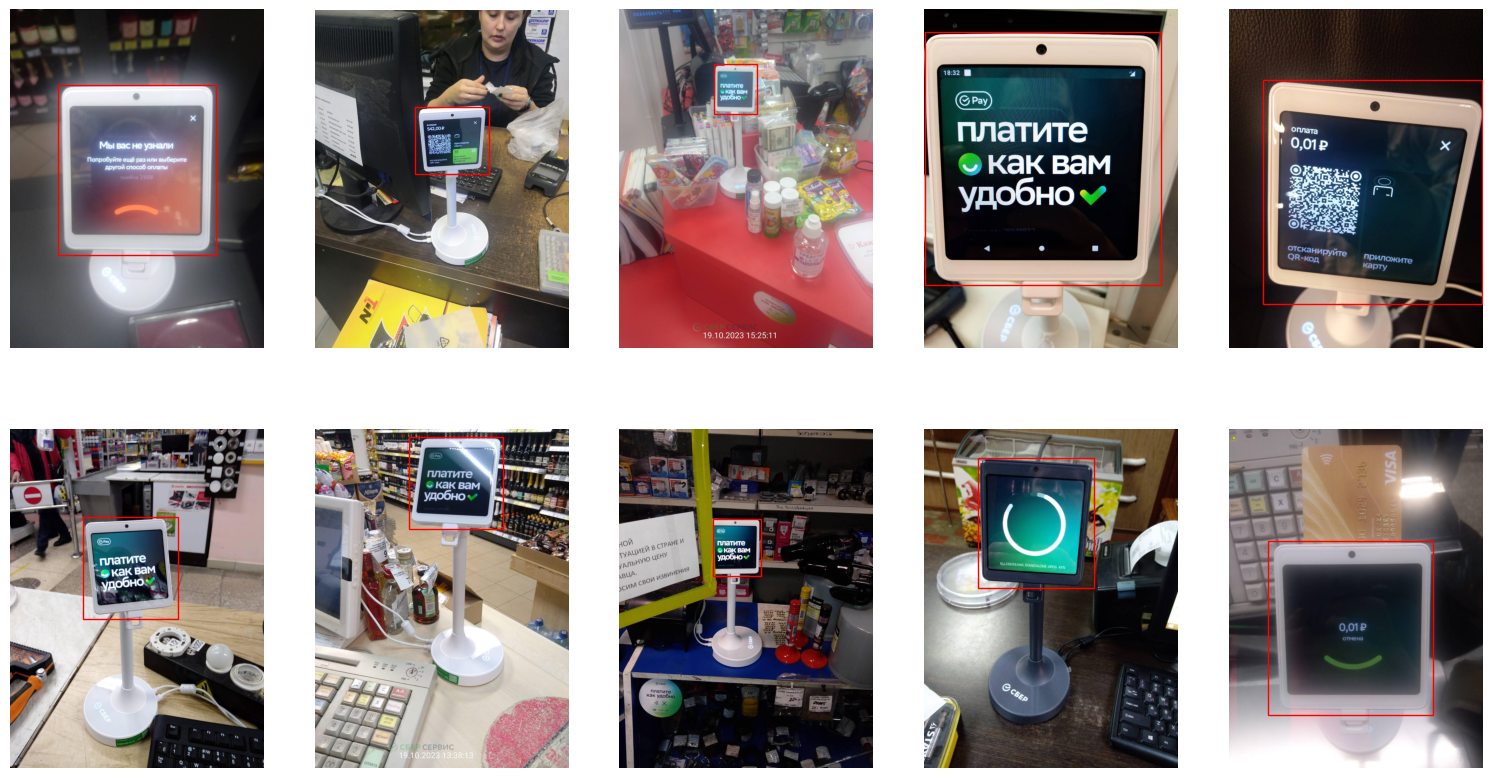

In [45]:
random_images = sample(sorted(df_merged_new['filename'].unique()), 10)
fig, axs = plt.subplots(2, 5, figsize=(19, 10))
for i, ax in enumerate(axs.ravel()):
    random_image = random_images[i]
    image = Image.open(random_image)
    ax.imshow(image)
    ax.axis('off')
    end = random_image.split('.')[-1]
    file_label = random_image.replace('photos', 'yolo_annot').replace(end, 'txt')
    markup = read_yolo_markup(file_label)
    for class_id, x_center, y_center, width, height in markup:
        x_c, y_c, w, h = (
            x_center * image.size[0], y_center * image.size[1], 
            width * image.size[0], height  * image.size[1]
        )
        x_min = (x_c - (w//2))
        y_min = (y_c - (h//2))
        rect = patches.Rectangle((x_min, y_min), w, h, linewidth=1,
                                    edgecolor='r', facecolor='none')
        ax.add_patch(rect)
plt.show()

# Удаление дубликатов

In [41]:
df_markup['flags'].value_counts()

receipts_augm                28832
terminals_augm                6981
pc_screens_augm               4792
receipts                      3604
terminals_side_view_augm      3424
other_augm                    3176
terminals                     2390
stickers_augm                 1520
new_terminals_augm             771
rack_new_terminal_augm         768
pc_screens                     599
terminals_side_view            428
other                          397
new_terminals                  292
stickers                       190
rack_new_terminal               96
terminals_receipt               11
wrong_photos_of_terminals        3
Name: flags, dtype: int64

In [45]:
def phash(filename) -> str:
    image = Image.open(filename)
    hash_size: int=8
    return str(
        hashlib.sha256(
            bytearray(
                imagehash.phash(
                    image, hash_size=hash_size
                ).hash.flatten().astype(int).tolist())
            ).hexdigest())

In [46]:
hashes = []
for filename in tqdm(df_markup['filename']):
    file_hash = phash(filename)
    hashes.append(file_hash)

100%|██████████| 58274/58274 [22:04<00:00, 43.99it/s] 


In [48]:
df_markup['hash'] = hashes
df_markup.sort_values(by='hash', inplace=True)

df_markup['hash'] = hashes
counter = Counter(df_markup['hash'])
df_hashes = pd.DataFrame(
    {
        'hash': list(counter.keys()),
        'count': list(counter.values())
    }
)
n_dupl = df_hashes[df_hashes['count']>1]['count'].sum()
print(f'Количество фото с дубликатами: {n_dupl}')

Количество фото с дубликатами: 38270


In [49]:
df_markup.drop_duplicates(subset=['hash'], inplace=True)
df_markup.reset_index(inplace=True, drop=True)
df_markup.to_pickle('markup.pkl')

# Формирование файлов с разметкой для антиклассов

In [48]:
df_markup['flags'].unique()

array(['new_terminals', 'other', 'pc_screens', 'rack_new_terminal',
       'receipts', 'stickers', 'terminals', 'terminals_receipt',
       'terminals_side_view', 'wrong_photos_of_terminals'], dtype=object)

In [49]:
stop_classes = ['new_terminals', 'terminals', 'terminals_receipt', 'wrong_photos_of_terminals']
df_anticlass = df_markup.loc[
    ~df_markup['flags'].isin(stop_classes)
]
df_anticlass.shape

(5314, 2)

In [71]:
for filename in tqdm(df_anticlass['filename']):
    folder_yolo_annot = path_yolo_annots / filename.split('\\')[-2]
    if not os.path.exists(folder_yolo_annot):
        os.makedirs(folder_yolo_annot)
    filename_markup = folder_yolo_annot / (filename.split('\\')[-1].split('.')[0] + '.txt')
    open(filename_markup, 'w').close()

100%|██████████| 5314/5314 [00:00<00:00, 9782.36it/s]


# Сохранение словаря с типами терминалов

In [75]:
with open('dict_terminal.json', 'w') as file:
    json.dump(dict_terminal_match, file)